In [ ]:
import os

os.environ["HF_HOME"] = "/n/netscratch/albergo_lab/Everyone/hf_cache"

from datasets import load_dataset
from transformers import GPT2TokenizerFast

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ds = load_dataset("openwebtext", num_proc=64)

Loading dataset shards:   0%|          | 0/83 [00:00<?, ?it/s]

In [ ]:
tokeniser = GPT2TokenizerFast.from_pretrained("gpt2")
detokeniser = None


def preprocess(sample):
    text = sample["text"]
    if detokeniser is not None:
        text = detokeniser(text)
    text = tokeniser(text, return_attention_mask=False)
    text["length"] = len(text["input_ids"])
    return text


tokenised_ds = ds.map(preprocess, num_proc=64)

In [ ]:
tokeniser = GPT2TokenizerFast.from_pretrained("gpt2")
detokeniser = None


def preprocess_batch(batch, max_length=512):
    all_input_ids = []
    all_lengths = []

    for text in batch["text"]:
        if detokeniser is not None:
            text = detokeniser(text)

        tokens = tokeniser(text, return_attention_mask=False)["input_ids"]
        chunks = [
            tokens[i : min(len(tokens), i + max_length)]
            for i in range(0, len(tokens), max_length)
        ]

        all_input_ids.extend(chunks)
        all_lengths.extend([len(chunk) for chunk in chunks])

    return {
        "input_ids": all_input_ids,
        "length": all_lengths,
    }


# Apply the function to the dataset using batched=True and remove_columns as needed
tokenised_ds_1 = ds.map(
    lambda batch: preprocess_batch(batch, max_length=1024),
    batched=True,
    num_proc=64,
    remove_columns=["text"],  # Optional, keeps things clean
)

Map (num_proc=64):   0%|          | 0/8013769 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1217 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1585 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1503 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1166 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1531 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

In [ ]:
tokeniser = GPT2TokenizerFast.from_pretrained("gpt2")
detokeniser = None


def find_delimiter_positions(tokens, delimiter_tokens):
    """Return the start indices where the delimiter occurs in the token sequence."""
    positions = []
    n = len(delimiter_tokens)
    for i in range(len(tokens) - n + 1):
        if tokens[i : i + n] == delimiter_tokens:
            positions.append(i)
    return positions


def recursive_split(tokens, max_length, delimiter_tokens):
    if len(tokens) <= max_length:
        return [tokens]

    # Find all positions where the delimiter sequence occurs
    split_candidates = find_delimiter_positions(tokens, delimiter_tokens)
    if not split_candidates:
        # Safe fallback: naive split
        return [
            tokens[i : min(i + max_length, len(tokens))]
            for i in range(0, len(tokens), max_length)
        ]

    # Find delimiter closest to the midpoint
    midpoint = len(tokens) // 2
    split_point = min(split_candidates, key=lambda x: abs(x - midpoint))

    # Recurse on both sides, skipping the delimiter
    dlen = len(delimiter_tokens)
    left = recursive_split(tokens[:split_point], max_length, delimiter_tokens)
    right = recursive_split(tokens[split_point + dlen :], max_length, delimiter_tokens)

    return left + right


def recursive_chunk_preprocess(batch, max_length=512):
    all_input_ids = []
    all_lengths = []

    for text in batch["text"]:
        if detokeniser is not None:
            text = detokeniser(text)

        tokens = tokeniser.encode(text, add_special_tokens=False)
        chunks = recursive_split(tokens, max_length, [198, 198])

        all_input_ids.extend(chunks)
        all_lengths.extend([len(chunk) for chunk in chunks])

    return {
        "input_ids": all_input_ids,
        "length": all_lengths,
    }


tokenised_ds_2 = ds.map(
    lambda batch: recursive_chunk_preprocess(batch, max_length=1024),
    batched=True,
    num_proc=64,
    remove_columns=["text"],
)

In [ ]:
def plot_lengths(length_list, log_scale=False):
    lengths_np = np.array(length_list)

    # Sort and compute CDF
    sorted_lengths = np.sort(lengths_np)
    cdf = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)

    # Compute percentiles
    percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]
    results = {p: int(np.percentile(lengths_np, p)) for p in percentiles}

    # Plot CDF
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_lengths, cdf, label="CDF of token lengths", color="blue")

    # Add percentile lines
    for p in percentiles:
        val = results[p]
        plt.axvline(val, color="red", linestyle="--", linewidth=1)
        plt.text(
            val,
            0.02,
            f"{p}%",
            rotation=90,
            color="red",
            fontsize=9,
            verticalalignment="bottom",
            horizontalalignment="right",
        )

    # Optional: reference max_length line

    # Labels and formatting
    plt.xlabel("Token Length")
    plt.ylabel("Cumulative Proportion")
    if log_scale:
        plt.xscale("log")
    plt.title("CDF of Tokenized Chunk Lengths with Percentile Markers")
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_3421044/2484663865.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/n/netscratch/albergo_lab/Lab/brianlck/interpretable-flow/.venv/lib64/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


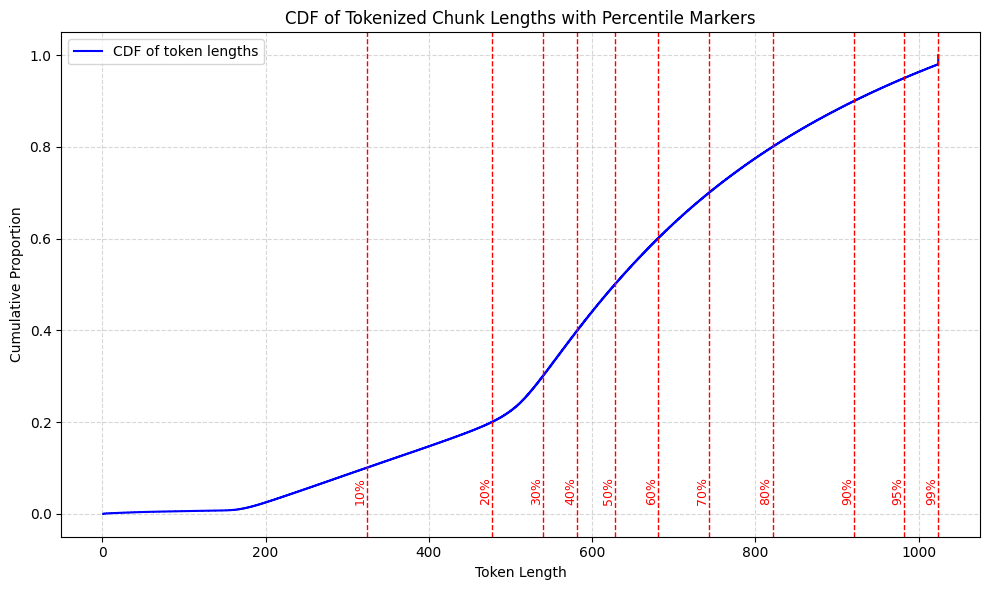

In [12]:
plot_lengths(tokenised_ds_2["train"]["length"])

/tmp/ipykernel_3421044/2484663865.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


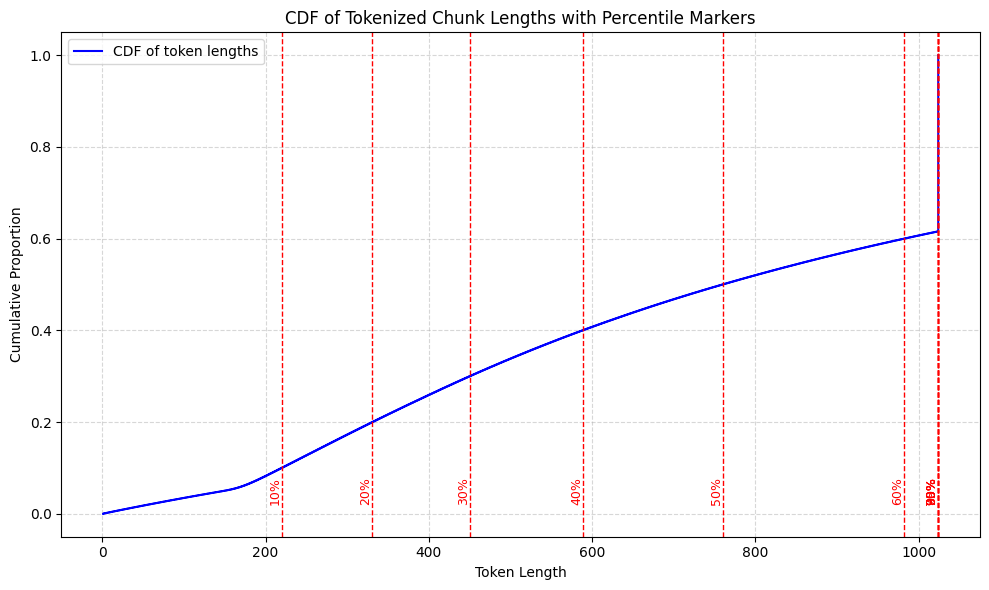

In [14]:
plot_lengths(tokenised_ds_1["train"]["length"])

/tmp/ipykernel_3421044/194231814.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/n/netscratch/albergo_lab/Lab/brianlck/interpretable-flow/.venv/lib64/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


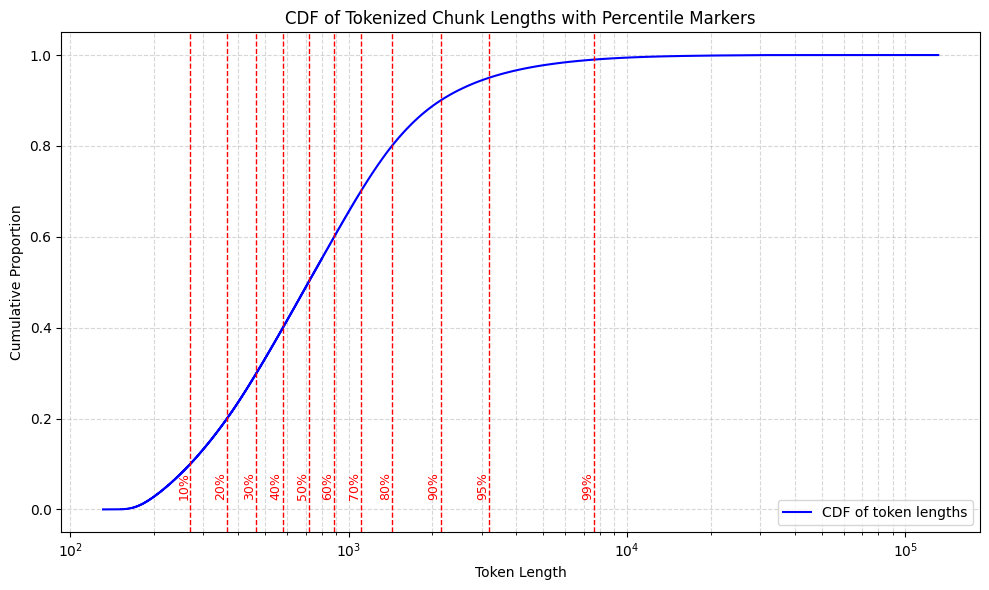

In [16]:
plot_lengths(tokenised_ds["train"]["length"], log_scale=True)